In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image, ImageFilter
from matplotlib import colormaps
import torch.optim as optim
import torch.nn as nn
from os import listdir
from os.path import isfile, join
import re
import random
import copy
from scipy.spatial import cKDTree
import pandas as pd
import math

In [15]:
def d2d(hyp, percent):
    theta = (3/4)*math.pi*percent
    x = math.cos(theta)*hyp
    y = math.sin(theta)*hyp
    return [percent, hyp]
# d2d

def read_and_save(file_path, start_line, output_file):
    with open(file_path, 'r') as file:
        # Skip lines until reaching the start_line
        for _ in range(start_line - 1):
            next(file)
        
        # Read the rest of the file and save to output_file
        with open(output_file, 'w') as output:
            for line in file:
                output.write(line)

#Read in lidar data
def data_xy(file, startPer, endPer):

    read_and_save(file, 36, 'output.txt')

    with open('output.txt', 'r') as file:
        data_str = file.read().strip()  # Read the content and remove leading/trailing whitespaces

# Remove the brackets and split the string at semicolons
    numbers = data_str[1:-1].split(';')
    #print(numbers)

# Convert each element to an integer
    numbers = [int(item.split('|')[0]) for item in numbers]

# make start and end indices for %
    whole = len(numbers)
    startDex = whole * startPer
    endDex = whole * endPer
    newArray = [numbers[math.floor(startDex)]]

# create new array with only points between % spec
    for i in range(len(numbers)):
        if (i > startDex) and (i < endDex):
            newArray = np.append(newArray, numbers[i])
# set old array = reduced array
    numbers = newArray

    # converts the numbers in the initial array into usable data
    twoDim = np.array([[0, 0]])  # Initialize an empty 2D array
# define twoDim as zeros of entire array, then change values instead of append
    
    for i in range(len(numbers)):
        # Create a 2D array for each number and append it to twoDim
        row = d2d(numbers[i], i / len(numbers) - 1)
        twoDim = np.append(twoDim, [row], axis=0)  # Append row along the rows axis

    return twoDim[1:, :]

def knn_heights(points, heights, k, min_height_difference):
    tree = cKDTree(points)
    indices = []
    
    for i, point in enumerate(points):
        # Query k nearest neighbors
        distances, neighbor_indices = tree.query(point, k=k+1)
        
        # Exclude the point itself from neighbors
        distances = distances[1:]
        neighbor_indices = neighbor_indices[1:]
        
        # Check height difference with neighbors
        for neighbor_index, distance in zip(neighbor_indices, distances):
            height_diff = abs(heights[i] - heights[neighbor_index])
            if height_diff >= min_height_difference:
                indices.append(i)
                break
    
    return indices

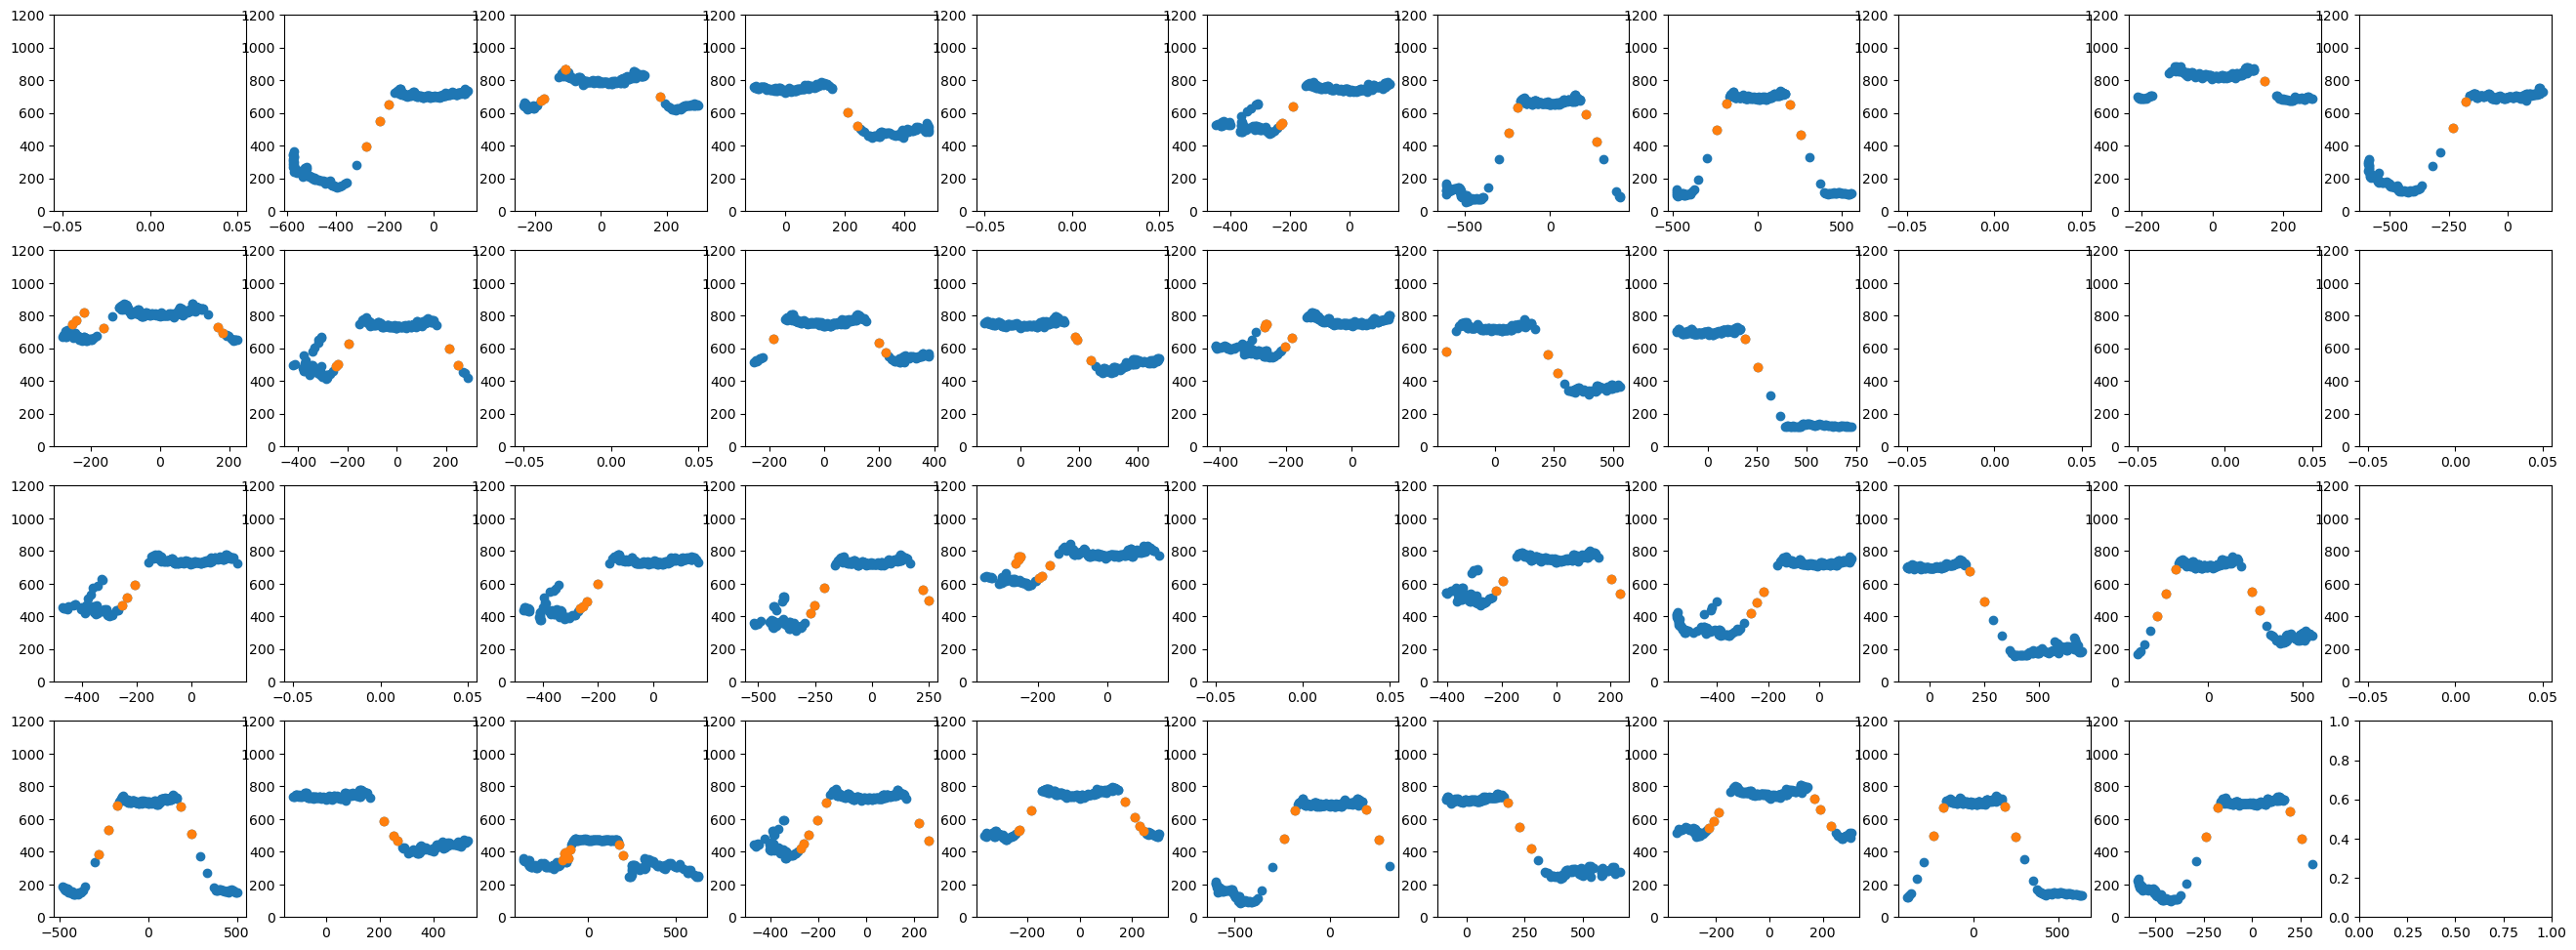

In [100]:
dir = "training_scans/"
size = 200 # how many points the lidar scans will be trimmed to
start = 0
stop = 1
k1 = 25
k2 = 35
dtheta = 0.25/180*np.pi # step size, radians
tank_height = 1.2192 * 1e3 # tank height in mm
theta0 = 35/180*np.pi # Initial angle of lidar scan, in radians

#########

scan_ls = []
edge_ls = []
all_files = [f for f in listdir(dir) if isfile(join(dir, f))]

files=[]
for file in all_files:
    match = re.search(".*\.ubh",file)
    if match != None:
        files.append(file)

fig, ax = plt.subplots(nrows = 4,ncols = len(files)//4+1,figsize=(3*(len(files)+1)//4,3*4))

count = 0
upper = 0

# Create dataset
for file in files:
    scan_rtheta = data_xy(str(str(dir)+file),start,stop)[1:-1,:] # read in lidar scan in r, theta coords. Cut off first and last point, which are always an error
    edge = np.zeros_like(scan_rtheta)                    # define edges as 0 everywhere
    edge_indices = knn_heights(scan_rtheta,scan_rtheta[:,1],k1,k2)  # Find indices of edges
    n = len(scan_rtheta) # how many points in this scan
    scan_rtheta[:,0] = np.linspace(-theta0,theta0,n) # recast index 0 as angle
    scan_xz = np.zeros_like(scan_rtheta) # array for xz coords
    scan_xz[:,0] = scan_rtheta[:,1]*np.sin(scan_rtheta[:,0])
    scan_xz[:,1] = tank_height - scan_rtheta[:,1]*np.cos(scan_rtheta[:,0])
    edge[:,0] = scan_xz[:,0] # give the edge points the same x axis
    edge[edge_indices,1] = 1 # set the points where edges were found to 1
    edge[edge[:,0]<-280,1] = 0 # manual override
    edge[edge[:,0]>280,1] = 0 # manual override
    cut = random.randint(-60,60) # pick random number to vary the cut
    cut_min = (n-size) // 2 + cut
    cut_max = cut_min + size
    scan_final = scan_xz[cut_min:cut_max,:]
    edge_final = edge[cut_min:cut_max,:]
    scan_ls.append(scan_final)
    edge_ls.append(edge_final)
    ax[0+upper,count].scatter(scan_final[:,0],scan_final[:,1])
    ax[0+upper,count].scatter(scan_final[edge_final[:,1]>0,0],scan_final[edge_final[:,1]>0,1])
    ax[0+upper,count].set_ylim(0,1200)
    
    if upper==0:
        upper=1
    elif upper==1:
        upper=2
    elif upper==2:
        upper=3
    else:
        count+=1
        upper=0
plt.savefig("training.png")

Epoch: 0


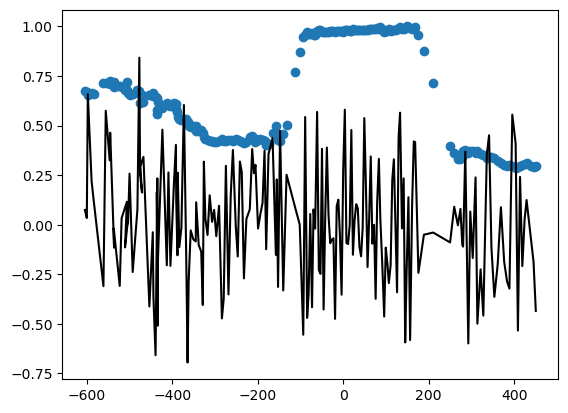

Epoch: 200000


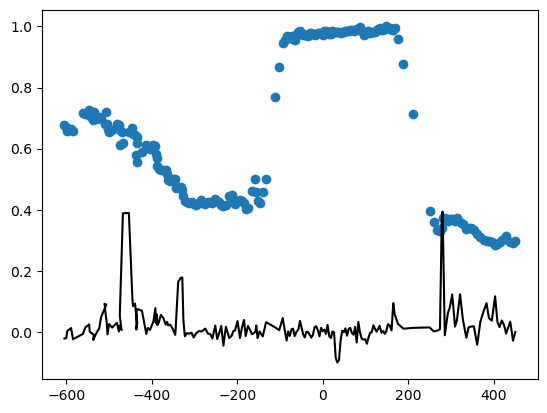

Epoch: 400000


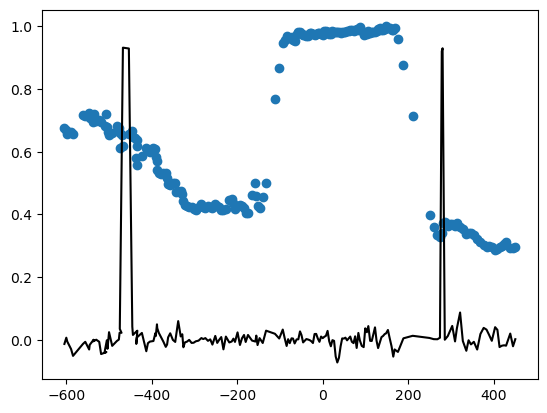

Epoch: 600000


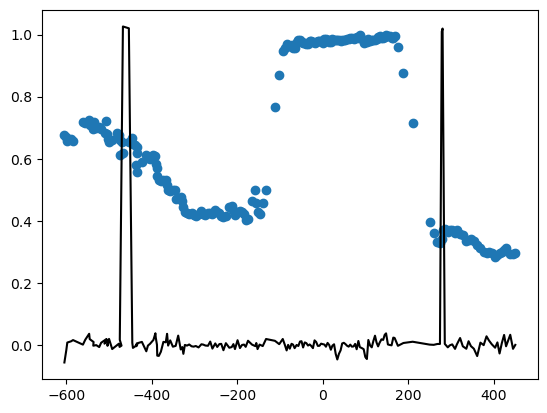

Epoch: 800000


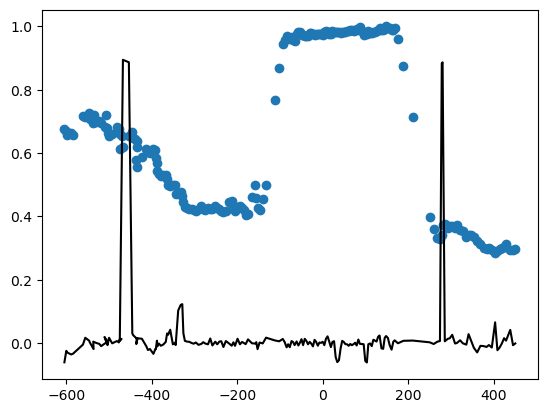

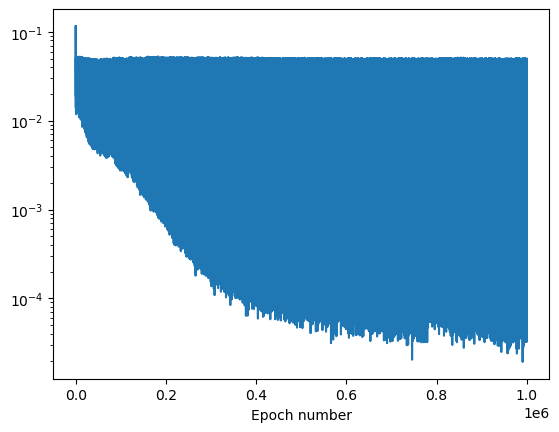

In [99]:
# ravel photo and edge arrays in 1d arra

device = 'cuda' if torch.cuda.is_available() else 'cpu'
myseed = 44
lr = 1e-1
n_epochs = 1000000
plot_every = n_epochs/5

# need to manually reshape the scan_ls such that each row is a bunch of scans
scan_array = np.zeros((len(scan_ls),size))
edge_array = np.zeros((len(scan_ls),size))
for i in range(len(scan_ls)):
    scan_array[i,:] = scan_ls[i][:,1]
    edge_array[i,:] = edge_ls[i][:,1]
scans_tensor = torch.tensor(scan_array)
edges_tensor = torch.tensor(edge_array)
x_train_tensor = scans_tensor.float().to(device) # only hand it the height values
y_train_tensor = edges_tensor.float().to(device)

test_scan = scans_tensor[0,:].float().to(device)
test_edge = edges_tensor[0,:].float().to(device)

torch.manual_seed(myseed)

hidden = 128
hidden2 = 128

model = nn.Sequential(
  nn.Linear(size, hidden),
  nn.Sigmoid(),
  nn.Linear(hidden, hidden2),
  nn.Sigmoid(),
  nn.Linear(hidden2,size),
).to(device)

def mse_loss(input, target):
    return ((input - target) ** 2).sum() / input.data.nelement()
    
optimizer = optim.SGD(model.parameters(), lr=lr)

losses = []

#Train
for epoch in range(n_epochs):

    num = random.randint(1,len(scan_ls)-1) # don't ever select the first row, that is kept separate for testing
    model.train()
    yhat = model(x_train_tensor[num])
    
    loss = mse_loss(y_train_tensor[num], yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss)

    if (epoch % plot_every)==0:
        print("Epoch:",epoch)
        fit = model(test_scan).cpu().detach().numpy()
        plt.plot(scan_ls[0][:,0],fit,color="black",label="edginess")
        plt.scatter(scan_ls[0][:,0],scan_ls[0][:,1]/scan_ls[0][:,1].max())
        plt.show()

losses_plot=[]
for i in losses:
    losses_plot.append(i.detach().numpy().item())

plt.plot(losses_plot)
plt.xlabel("Epoch number")
plt.yscale("log")
plt.show()

In [77]:
scan_array

array([[330.03403714, 311.86390316, 311.10894769, ..., 140.35114689,
        144.74645564, 145.58039256],
       [668.34313352, 663.59979767, 672.56439132, ..., 669.87914869,
        674.63179888, 673.07145315],
       [461.50062895, 457.20962635, 459.26998587, ..., 470.1888898 ,
        468.94205293, 468.62929047],
       ...,
       [148.78144187, 154.94804388, 143.73189395, ..., 147.67055741,
        142.75123211, 142.37024016],
       [265.95380621, 271.1352619 , 270.94691347, ..., 225.47076386,
        242.02029151, 250.32082944],
       [ 83.97617814,  91.00472918,  97.21220034, ..., 123.71495362,
        125.8199168 , 124.46980055]])